In [5]:
import pandas as pd 
import spacy
from nltk.tokenize import RegexpTokenizer
from spacy.lang.en import stop_words
from nltk.corpus import stopwords

In [6]:
dataset_training = pd.read_csv("twitter_training.csv",names=["id","entity","sentiment","tweet"])
dataset_training.dropna(inplace=True)

In [7]:
dataset_training

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [8]:
entity = dataset_training["entity"].value_counts()

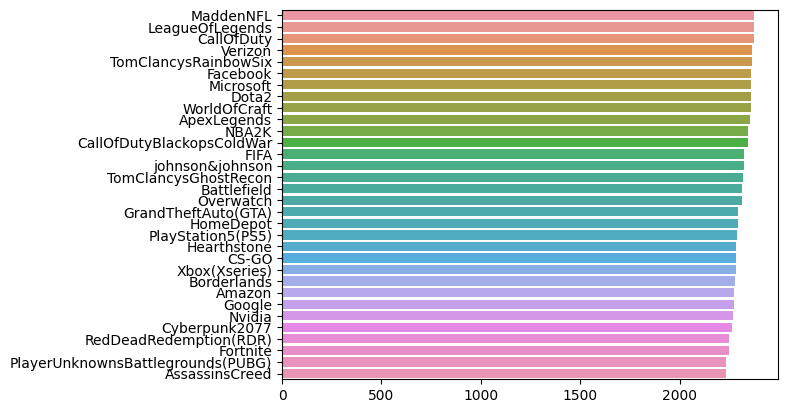

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = sns.barplot(y=entity.index, x=entity.values,orient="h")
plt.savefig("assuntos.png")

In [22]:
quantity = dataset_training["sentiment"].value_counts()

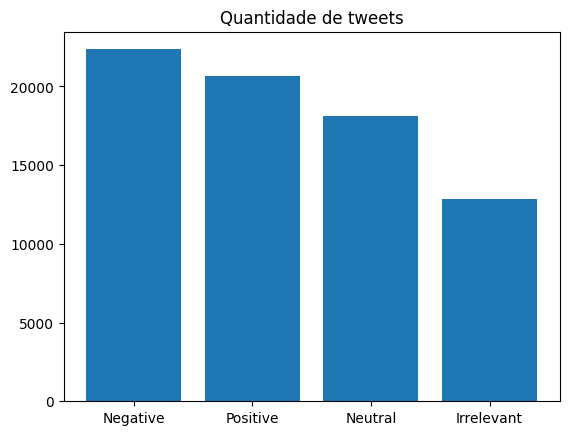

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(quantity.index.tolist(),height=quantity.values)
ax.set_title("Quantidade de tweets")
plt.savefig("quantidade_de_tweets.png")

In [6]:
tweets = dataset_training['tweet']
sentiment = dataset_training['sentiment']

In [7]:
tweets

0        im getting on borderlands and i will murder yo...
1        I am coming to the borders and I will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    Just realized that the Windows partition of my...
74678    Just realized that my Mac window partition is ...
74679    Just realized the windows partition of my Mac ...
74680    Just realized between the windows partition of...
74681    Just like the windows partition of my Mac is l...
Name: tweet, Length: 73996, dtype: object

# Pré-processamento

In [8]:
sample = tweets.iloc[68]

In [9]:
sample

"Going to finish up Borderlands 2 today. I've got some new events set up and am look forward to a good stream! Starting in about 20 hour!"

In [10]:
def tokenizer_tweet(tweet):
    tokenizer = RegexpTokenizer(r"\w+|[0-9]")
    tokenized_tweet = tokenizer.tokenize(tweet)
    return tokenized_tweet
    

In [11]:
sample_tokenized = tokenizer_tweet(sample)

In [12]:
sample_tokenized

['Going',
 'to',
 'finish',
 'up',
 'Borderlands',
 '2',
 'today',
 'I',
 've',
 'got',
 'some',
 'new',
 'events',
 'set',
 'up',
 'and',
 'am',
 'look',
 'forward',
 'to',
 'a',
 'good',
 'stream',
 'Starting',
 'in',
 'about',
 '20',
 'hour']

In [13]:
stop_words_nltk = set(stopwords.words('english'))
all_stopwords = stop_words.STOP_WORDS.union(stop_words_nltk) 

def remove_stopwords(tokens):
    tweet_without_stopwords = []
    for token in tokens:
        if token not in all_stopwords:
            tweet_without_stopwords.append(token)
    return tweet_without_stopwords

In [14]:
sample_without_stopwords = remove_stopwords(sample_tokenized)

In [15]:
def lower_tweet(tokens):
    return [token.lower() for token in tokens]

In [16]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_tweet(tokens):
    tweet = " ".join(token for token in tokens)
    doc = nlp(tweet)
    return [token.lemma_ for token in doc]

In [17]:
def pipeline(tweet):
    new_tweet = tokenizer_tweet(tweet)
    new_tweet = remove_stopwords(new_tweet)
    new_tweet = lower_tweet(new_tweet)
    new_tweet = lemmatize_tweet(new_tweet)
    
    return new_tweet

In [18]:
pipeline(sample)

['go',
 'finish',
 'borderland',
 '2',
 'today',
 'I',
 'get',
 'new',
 'event',
 'set',
 'look',
 'forward',
 'good',
 'stream',
 'start',
 '20',
 'hour']

In [19]:
tweet_preprocess = tweets.apply(lambda x: pipeline(x))

# Word2vec

In [20]:
from gensim.models import Word2Vec
import os

In [21]:
if os.path.isfile("twweets_model_100.model"):
    w2v = Word2Vec.load("twweets_model_100.model")
else:
    w2v = Word2Vec(sentences=tweet_preprocess.values.tolist(),vector_size=100,min_count=1,window=5)
    w2v.train(tweet_preprocess.values.tolist(),total_examples=5,epochs=10)
    w2v.save("twweets_model_100.model")

In [22]:
weights = w2v.wv.vectors
vocab = w2v.wv.index_to_key

In [23]:
length_vocab = len(vocab)

In [24]:
qt_tokens = tweet_preprocess.apply(lambda x: len(x))

In [25]:
MAX_TOKENS = max(qt_tokens)

## Modelagem

In [30]:
from tensorflow.keras.layers import TextVectorization, LSTM, Dense, Embedding, Activation, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model
from tensorflow.ragged import constant
from sklearn.model_selection import train_test_split

In [33]:
tweets_train, tweets_test, sentiment_train, sentiment_test = train_test_split(tweet_preprocess,sentiment,test_size=0.2)

In [34]:
t2v = TextVectorization(max_tokens=None, standardize=None, split=None, output_sequence_length=MAX_TOKENS+1, vocabulary=vocab)

In [35]:
X_train = constant(tweets_train.values.tolist())
X_test = constant(tweets_test.values.tolist())

In [37]:
y_train = sentiment_train.replace({"Negative":0,"Positive":3,"Neutral":2, "Irrelevant":1}).values
y_test = sentiment_test.replace({"Negative":0,"Positive":3,"Neutral":2, "Irrelevant":1}).values

y_train = to_categorical(y_train, 4)


In [39]:
X_train_vec = t2v(X_train)

In [40]:
X_train_vec

<tf.Tensor: shape=(59196, 199), dtype=int64, numpy=
array([[   7,    8,  407, ...,    0,    0,    0],
       [ 176,  165,  124, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 226,  214,  424, ...,    0,    0,    0],
       [  20,   90,  148, ...,    0,    0,    0],
       [   7, 2428,  975, ...,    0,    0,    0]])>

In [76]:
input_model = Input(shape=X_train_vec.shape[1:])
tensor = Embedding(weights=[weights],input_length=MAX_TOKENS+1,input_dim=weights.shape[0],output_dim=weights.shape[1])(input_model)
tensor = LSTM(100,return_sequences=True)(tensor)
vec = Flatten()(tensor)
vec = Dense(100)(vec)
vec = Dense(4)(vec)
output_model = Activation(activation='softmax')(vec)

model = Model(input_model,output_model)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 199)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 199, 100)          2726400   
                                                                 
 lstm_1 (LSTM)               (None, 199, 100)          80400     
                                                                 
 flatten_1 (Flatten)         (None, 19900)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               1990100   
                                                                 
 dense_3 (Dense)             (None, 4)                 404       
                                                                 
 activation_1 (Activation)   (None, 4)                 0   

In [77]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [78]:
history = model.fit(X_train_vec,y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1)

Epoch 1/10
1665/1665 [==============================] - 25s 14ms/step - loss: 1.0792 - accuracy: 0.5998 - val_loss: 0.5379 - val_accuracy: 0.7958
Epoch 2/10
1665/1665 [==============================] - 24s 14ms/step - loss: 0.3331 - accuracy: 0.8749 - val_loss: 0.3823 - val_accuracy: 0.8637
Epoch 3/10
1665/1665 [==============================] - 24s 14ms/step - loss: 0.2170 - accuracy: 0.9166 - val_loss: 0.3962 - val_accuracy: 0.8699
Epoch 4/10
1665/1665 [==============================] - 24s 14ms/step - loss: 0.1717 - accuracy: 0.9331 - val_loss: 0.3954 - val_accuracy: 0.8811
Epoch 5/10
1665/1665 [==============================] - 24s 14ms/step - loss: 0.1416 - accuracy: 0.9443 - val_loss: 0.4418 - val_accuracy: 0.8814
Epoch 6/10
1665/1665 [==============================] - 24s 14ms/step - loss: 0.1182 - accuracy: 0.9525 - val_loss: 0.5093 - val_accuracy: 0.8831
Epoch 7/10
1665/1665 [==============================] - 24s 14ms/step - loss: 0.1016 - accuracy: 0.9587 - val_loss: 0.5825 -

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score

In [80]:
X_test_vec = t2v(X_test)
y_pred = model.predict(X_test_vec)

463/463 [==============================] - 2s 4ms/step


In [81]:
y_pred = y_pred.argmax(1)

In [83]:
print("acuracia:{:.2f}".format(accuracy_score(y_test,y_pred)))
print("precisao:{:.2f}".format(precision_score(y_test,y_pred,average="macro")))
print("revocacao:{:.2f}".format(recall_score(y_test,y_pred,average="macro")))
print("f1-score:{:.2f}".format(f1_score(y_test,y_pred,average="macro")))

acuracia:0.89
precisao:0.89
revocacao:0.88
f1-score:0.89


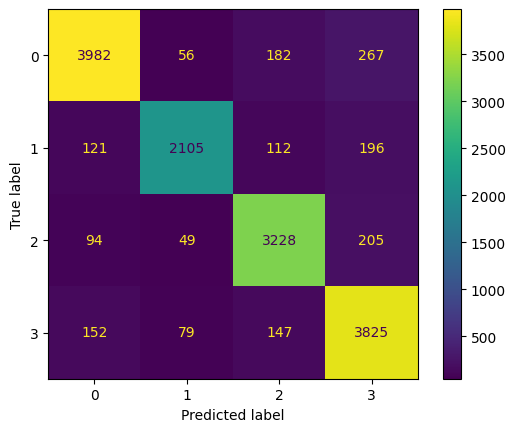

In [84]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)